# How many of the functions are actually used?

In this notebook we'll import data about functions that [we've harvested earlier](harvesting_functions_from_recordsearch.ipynb) and search for each of these functions in RecordSearch to see how many are actually used.

In [13]:
import json
import pandas as pd
from tqdm import tqdm_notebook
import altair as alt
from recordsearch_tools.client import RSAgencySearchClient

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Load and prepare the data

In [14]:
# Load the JSON file we've already harvested
with open('data/functions.json', 'r') as json_file:
    functions = json.load(json_file)

In [15]:
def get_children(function):
    f_list = []
    if 'narrower' in function:
        for subf in function['narrower']:
            f_list.append(subf['term'])
            f_list += get_children(subf)
    return f_list

functions_list = []
for function in functions:
    functions_list.append(function['term'])
    functions_list += get_children(function)

In [16]:
# Get rid of duplicates
functions_list = set(functions_list)
# Sort terms
sorted(functions_list)

['accommodation services',
 'acquisition',
 'administrative decision appeal',
 'administrative decision review',
 'administrative law',
 'administrative services',
 'advertising standards',
 'aged persons services',
 'agricultural sciences',
 'agriculture',
 'air force',
 'air force administration',
 'air force commands',
 'air operations',
 'air safety',
 'air transport',
 'air transport safety',
 'aircraft standards',
 'airport services',
 'airports',
 'ambulance services',
 'analytical services',
 'animal and veterinary sciences',
 'applications for native title',
 'applied sciences',
 'arbitration',
 'archives administration',
 'army',
 'army administration',
 'army commands',
 'artifact export regulation',
 'arts',
 'arts development',
 'arts funding',
 'arts incentive schemes',
 'arts promotion',
 'associations and corporate law',
 'atmospheric sciences',
 'audit',
 'australian capital territory',
 'australian defence forces (adf)',
 'banking',
 'bankruptcy',
 'biological science

## Search for agencies associated with each function

In RecordSearch, functions are performed by agencies. So when you search for a function you get back a list of agencies. Here we'll loop through the list of functions and search for associated agencies.

In [17]:
function_totals = []
# Use the agency search code in my recordsearch_tools library
rsclient = RSAgencySearchClient()
for function in tqdm_notebook(functions_list):
    agencies = rsclient.search_agencies(function=function, results_per_page=0)
    # Get the total results from each search (replace None with 0)
    total = 0 if agencies['total_results'] == None else int(agencies['total_results'])
    function_totals.append({'function': function, 'total': total})

## Explore the results

In [18]:
# Create a DataFrame with the results
df = pd.DataFrame(function_totals)

In [19]:
df.describe()

,total
count,472.000000
mean,26.777542
std,52.284938
min,0.000000
25%,0.000000
50%,0.000000
75%,28.000000
max,417.000000


So 75% of all functions have less than 28 associated agencies.

How many are actiually used?

In [20]:
# How many functions are actually used
used = df.loc[df['total'] > 0].count()
print(used['total'])

229


In [21]:
percent_used = used['function'] / len(functions_list)
print('{:.1%} of the functions are used'.format(percent_used))

48.5% of the functions are used


In [22]:
# Most used function
df.loc[df['total'] == df['total'].max()]

,function,total
363,employment,417


In [23]:
# Top 20 by number of agencies
df.sort_values(by='total', ascending=False)[:20]

,function,total
363,employment,417
277,education,292
36,army commands,286
416,social welfare,268
376,indigenous affairs,267
244,training,230
219,housing,220
426,scientific research,212
136,migration,198
290,goods and services,195


## Show how agencies are distributed across functions

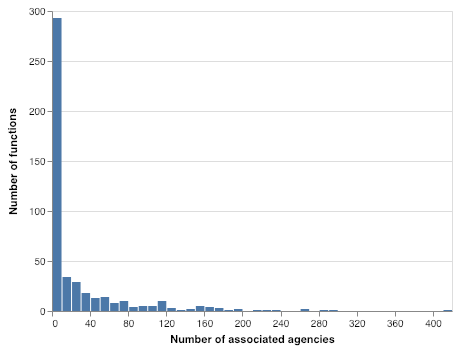

In [24]:
# Bin the agencies to make it wasier to read
alt.Chart(df).mark_bar().encode(
    x=alt.X('total:Q', bin=alt.Bin(step=10), title='Number of associated agencies'),
    y=alt.Y('count()', title='Number of functions'),
    tooltip=[alt.Tooltip('total:Q', bin=alt.Bin(step=10), title='Agencies'), alt.Tooltip('count()', title='Functions')]
)